#2023년 2학기
영남대학교 전자공학과
종합설계논문

23년 2학기 종합설계(2)과제 9조 손창우 입니다.
만나서 반갑습니다.

해당 과제에서는 기존 2차원(X,Y)축을 사용하던 QR코드의 한계를 넘어 RGB축을 기반으로 한 "3차원 암호화 전달체계"를 만들어보고자 시작되었습니다.

#개요 설명 및 라이브러리 다운로드

In [ ]:
#해당 프로젝트에서 사용하는 나눔폰트 다운로드입니다.
#한글 사용을 위해 필수적인 과정이오나, 다운 이후 런타임을 재시행 해야 적용이 되므로 해당 코드를 실행 후 새로고침 또는 런타임 재실행 부탁드립니다.
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv


In [ ]:
!pip install qrcode
!pip install opencv-python
!pip install easyocr
!pip install pyzbar
!rm ~/.cache/matplotlib -rf
!apt install libzbar0
#다운 이후에
#import 해줘야죠
import cv2
import easyocr
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import qrcode
import base64
from pyzbar.pyzbar import decode
import ast
import torch
import torchvision.models as models

reader = easyocr.Reader(['ko','en'], model_storage_directory='/content/drive/MyDrive/g2')


-작업에 필요한 구성요소들을 다운로드 해줍니다. 꼭 필요한 과정입니다.

-qrcode는 QR코드의 생성 및 인식에 필요한 라이브러리로, colab에서 기본지원되지 않기에 다운로드가 필요합니다.

-opencv는 이미지 loading 과 저장을 용이하게 하기위해 import합니다.

-easyocr은 사전 교육이 필요한 tesserect와 달리 높은 신뢰성과 동시에 여러가지 언어를 인식하는데에 뛰어나 택하게 되었습니다.

-OCR이란 Optical Character Recognition, 광학 문자 인식 이란 뜻이며 이미지에서 문자를 찾아내는 객체탐색 알고리즘입니다.


Pre_trained 된 한국어 인식 모델을 불러오겠습니다.

#QR코드 직접 만들어보기!

마트에서 흔히보이는 바코드 입니다. 선의 굵기와 위치에 따라 다른 정보를 담고 있는 **"1차원"** 정보전달 이미지 매개체라고 할 수 있죠!

-우리 주변에 널리 퍼져있는 QR코드는 'Quick Response' 라는 뜻으로 1994년 일본의 덴소웨이브가 만들었습니다. 지금은 누구나 무료로 얼마든 마음대로! QR코드를 만들고 쓸 수 있죠!

-한번 해보시겠습니까?

In [ ]:
def make_own_qr(data):
    qr = qrcode.QRCode(
        version=1,
        error_correction=qrcode.constants.ERROR_CORRECT_L,
        box_size=10,
        border=2,
    )
    qr.add_data(data)
    qr.make(fit=True)
    img = qr.make_image(fill_color="black", back_color="white")
    return img

data = input(f"QR코드를 맘껏 만들어 보세요!:")
img1 = make_own_qr(data)
img1.save("yourqr.png")

I = cv2.imread('yourqr.png')
cv2_imshow(I)
print("스마트폰으로 캡처해보세요, 놀랄걸요?")

-그럼 이제 3차원 QR을 만들어볼까요?
**각 문자열의 길이가 너무 다르면 QR의 크기가 달라집니다.**

In [ ]:
data1 = input("첫 번째 문자열을 입력하세요: ")
data2 = input("두 번째 문자열을 입력하세요: ")
data3 = input("세 번째 문자열을 입력하세요: ")
data4 = input("네 번째 문자열을 입력하세요: ")
data5 = input("다섯 번째 문자열을 입력하세요: ")
data6 = input("여섯 번째 문자열을 입력하세요: ")

img1 = make_own_qr(data1)
img1.save("qr1.png")
img2 = make_own_qr(data2)
img2.save("qr2.png")
img3 = make_own_qr(data3)
img3.save("qr3.png")
img4 = make_own_qr(data4)
img4.save("qr4.png")
img5 = make_own_qr(data5)
img5.save("qr5.png")
img6 = make_own_qr(data6)
img6.save("qr6.png")

im = []
im.append(cv2.imread('qr1.png', cv2.IMREAD_GRAYSCALE))
im.append(cv2.imread('qr2.png', cv2.IMREAD_GRAYSCALE))
im.append(cv2.imread('qr3.png', cv2.IMREAD_GRAYSCALE))
im.append(cv2.imread('qr4.png', cv2.IMREAD_GRAYSCALE))
im.append(cv2.imread('qr5.png', cv2.IMREAD_GRAYSCALE))
im.append(cv2.imread('qr6.png', cv2.IMREAD_GRAYSCALE))
h, w = im[0].shape
corqr3 = np.zeros((h, w, 3), dtype=np.uint8)
corqr3[:, :, 2] = np.round(im[2]/3) + np.round(im[5]*0.6) # Red 채널: im3 값 할당
corqr3[:, :, 1] = np.round(im[1]/3)  + np.round(im[4]*0.6)# Green 채널: im2 값 할당
corqr3[:, :, 0] = np.round(im[0]/3)  + np.round(im[3]*0.6)# Blue 채널: im1 값 할당

cv2.imwrite('corqr.png', corqr3)
cv2_imshow(corqr3)

처음보는 3차원 QR이 어떤가요?

#EasyOCR을 사용하여 텍스트 객체 인식하기

이제, 여러분이 직접 텍스트이미지를 만들어 볼까요?
**나눔폰트가 없다고 나올 경우 코랩런타임을 다시 시작 해 주세요**

In [ ]:
plt.rc('font', family='NanumBarunGothic')
def create_image_with_text(text, file_name):
    plt.figure(figsize=(4, 2))  # 이미지 크기 설정
    plt.text(0.5, 0.5, text, ha='center', va='center', fontsize=12)  # 중앙에 텍스트 추가
    plt.axis('off')  # 축 제거

    # 이미지 파일로 저장
    plt.savefig(file_name, bbox_inches='tight', pad_inches=0)
    plt.close()

user_input = input("저장할 문자열을 입력하세요: ")
create_image_with_text(user_input, 'capture.jpg')

I = cv2.imread('capture.jpg')
cv2_imshow(I)

이걸론 모자랍니다. 세줄정도는 적어보자구요

적을 내용이 없다면.... **전자과 삼행시**는 어떠신가요?

In [ ]:
ㅎdef create_image_with_poem(poem,file_name):

    plt.figure(figsize=(6, 4))  # 이미지 크기 설정
    plt.text(0.5, 0.8, poem[0], ha='center', va='center', fontsize=14)  # 전
    plt.text(0.5, 0.5, poem[1], ha='center', va='center', fontsize=14)  # 자
    plt.text(0.5, 0.2, poem[2], ha='center', va='center', fontsize=14)  # 과
    plt.axis('off')  # 축 제거
    # 이미지 파일로 저장
    plt.savefig(file_name, bbox_inches='tight', pad_inches=0)
    plt.close()
# 사용자 입력 받기
top_text_input = input("전!: ")
middle_text_input = input("자!: ")
bottom_text_input = input("과!: ")
# 프리픽스 추가
top_text = "전: " + top_text_input
middle_text = "자: " + middle_text_input
bottom_text = "과: " + bottom_text_input
poem = [top_text,middle_text,bottom_text]
create_image_with_poem(poem,'capture.jpg')

cv2_imshow(cv2.imread('capture.jpg'))

아...훌륭한 삼행시 입니다! 저희 말고 Python도 이 내용을 봤으면 좋겠네요...

easyocr의 힘을 이용한다면, 불가능한 일은 아니죠!

**최초실행시 easyocr의 로딩을 기다려주세요**

In [ ]:
input_image = cv2.imread('capture.jpg')
cv2_imshow(input_image)
result = reader.readtext('capture.jpg')

# 텍스트 부분만 출력
for detection in result:
    text = detection[1]  # 각 요소의 두 번째 항목이 텍스트
    print(text)

print("\n")
print("아...참 재미있군요!")

-파이썬이 여러분의 문학작품을 높이 평가한 것이 확인 되었다면, 다음 코드를 통해 이미지에서 text를 추출한 뒤 해당 텍스트에는 모자이크를, 새로운 템플릿에는 내용을 붙여넣기하는 "저희가 만들어낸 코드를" 시행해 보세요

In [ ]:
# 이미지 열기
img = cv2.imread('capture.jpg')

# 텍스트 추출
result = reader.readtext('capture.jpg')
print(result)
# 텍스트와 위치 저장
texts = []
boxes = []

for detection in result:
    text = detection[1]
    box = detection[0]

    texts.append(text)
    boxes.append(box)
print(texts)
print(boxes)
# 검은 상자로 원본 이미지의 텍스트 가리기
for box in boxes:
    top_left, _, bottom_right, _ = box
    img = cv2.rectangle(img, tuple(top_left), tuple(bottom_right), (0, 0, 0), -1)

# 검은 상자로 가려진 이미지 출력
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Output Image 1: 내용이 모자이크 된 이미지')
plt.axis('off')
plt.show()

# 백지에 텍스트 그리기
blank_img = np.ones_like(img) * 255  # 흰색 이미지 생성

#폰트 로드
font = ImageFont.truetype('NanumBarunGothic', 20)

# 텍스트와 상자 그리기
pil_img = Image.fromarray(blank_img)
draw = ImageDraw.Draw(pil_img)

for text, box in zip(texts, boxes):
    top_left, _, bottom_right, _ = box
    draw.text((top_left[0], top_left[1]), text, font=font, fill=(0, 0, 0))

text_img = np.array(pil_img)

# 백지에 텍스트가 있는 이미지 출력
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(text_img, cv2.COLOR_BGR2RGB))
plt.title('Output Image 2:원본 내용이 붙여넣기된 이미지.')
plt.axis('off')
plt.show()


-결과가 어땟나요? Tesseract와는 달리, easyocr은 여러가지 언어를 기본적으로 제공하며 단어와 문단의 개념을 알기에 비교적 깔끔한
 "텍스트 객체 추출"을 지원합니다.

-그리고 추가 교육(파인튜닝)이 필요한 Tesseract와 달리 기본 제공 모델만으로도 높은 정확도를 보여줍니다.

**단어 및 문단단위의 텍스트 객체 추출은 이번 과제에서 EasyOCR을 사용한 가장 큰 이유입니다!**

-그럼 다시 QR로 돌아가서...

#사용자가 입력한 정보로 3차원 QR 생성하기

지금부터 당신은 병원의 의사가 되었다고 가정해 봅시다.

당신은 매우 민감한 사항을 가진 환자의 진료를 맡고 있습니다.

당신 앞의 환자에 대한 간단한 소견을 적어주실 수 있나요? ("내용은 비밀이 보장됩니다")

***개인정보에 대한 입력은 임의로 아무거나 치세요!! 실제 QR이 저장되므로 위험이 있습니다.***

**비밀번호는 1,2,3,4,5,6 을 한번씩 6자리로 만들어 주세요 **

In [ ]:
# QR 코드를 생성하는 함수
def generate_fixed_size_qr_code(data):
    qr = qrcode.QRCode(
        version=1,  # 동일한 버전 사용 (1은 가장 작은 크기)
        error_correction=qrcode.constants.ERROR_CORRECT_L,
        box_size=20,  # 동일한 상자 크기
        border=1,  # QR 코드 주변의 여백
    )
    qr.add_data(data)
    qr.make(fit=True)
    img = qr.make_image(fill_color="black", back_color="white")
    return img
def qrencode(file_content,password):
      saved_string = file_content
      saved_string = base64.b64encode(saved_string.encode()).decode()

      # 텍스트를 5등분
      # 등분할 텍스트의 크기 계산
      chunk_size = len(saved_string) // 6  # 초기 등분 크기
      remainder = len(saved_string) % 6  # 나머지 계산

      # 텍스트를 여섯 부분으로 분할하여 등분 크기 조정
      chunks = []
      start = 0
      for i in range(6):
          extra = 1 if i < remainder else 0  # 나머지를 고려하여 추가 부분 할당
          end = start + chunk_size + extra
          chunks.append(saved_string[start:end])
          start = end


      # 남은 부분을 data6에 할당하고 부족한 만큼 공백을 추가
      data1, data2, data3, data4, data5, data6= chunks

      # QR 코드 생성 및 이미지 저장.
      # QR 코드를 생성하고 이미지를 리스트에 저장
      im = []

      img1 = generate_fixed_size_qr_code(data1)
      img1.save("testqr1.png")
      img2 = generate_fixed_size_qr_code(data2)
      img2.save("testqr2.png")
      img3 = generate_fixed_size_qr_code(data3)
      img3.save("testqr3.png")
      img4 = generate_fixed_size_qr_code(data4)
      img4.save("testqr4.png")
      img5 = generate_fixed_size_qr_code(data5)
      img5.save("testqr5.png")
      img6 = generate_fixed_size_qr_code(data6)
      img6.save("testqr6.png")

      im = []

      im.append(cv2.imread("testqr1.png",0))
      im.append(cv2.imread("testqr2.png",0))
      im.append(cv2.imread("testqr3.png",0))
      im.append(cv2.imread("testqr4.png",0))
      im.append(cv2.imread("testqr5.png",0))
      im.append(cv2.imread("testqr6.png",0))


      #비번 설정
      pw = [int(char) for char in password if char.isdigit()]
      imgarr = [None]*len(pw)

      for i in range(len(imgarr)):
        imgarr[i]=im[pw[i]-1]

      # 이미지를 합치기 위한 빈 RGB 이미지 생성
      h,w = im[0].shape
      result = np.zeros((h, w, 3), dtype=np.uint8)

      # im1, im2, im3의 값에 따라 R, G, B 채널에 할당
      result[:, :, 2] = np.round(imgarr[2]/3) + np.round(imgarr[5]*0.6) # Red 채널: im3 값 할당
      result[:, :, 1] = np.round(imgarr[1]/3)  + np.round(imgarr[4]*0.6)# Green 채널: im2 값 할당
      result[:, :, 0] = np.round(imgarr[0]/3)  + np.round(imgarr[3]*0.6)# Blue 채널: im1 값 할

      return(result)
#사용자 정보를 입력 받을 공간
information_names = ['이름', '나이', '주민등록번호','의료기관 명칭','의료기관 전화번호','의료기관 fax','의사의 소견','환자 특이사항','환자 희망 기재사항','치료이력']
user_info = {}

for info_name in information_names:
    user_input = input(f"{info_name}을(를) 입력하세요: ")
    user_info[info_name] = user_input

file_content_list = [f"{user_info[name]}" if name != '나이' else f"{user_info[name]}세" for name in information_names]
file_content = ' '.join(file_content_list)

file_path = 'user_info.txt'

with open(file_path, 'w') as file:
    file.write(file_content)

#사용자 정보를 저장함
print(f"파일이 {file_path} 경로에 저장되었습니다.")


pw = input("비밀번호 입력하기:")
result = qrencode(file_content,pw)
cv2.imwrite('result.png',result)
cv2_imshow(result)




방금. 당신이 쓴 정보를 담은 3차원 QR코드입니다! 아주 멋지지 않나요? 그러나, 일반 QR코드 스캐너로는
정보를 알아낼 수 없을겁니다. (장담해요) :)

#내용을 인식해 봐야겠죠? QR 디코딩 단계입니다.

그럼 아까의 정보를 다시 불러와 볼까요?

In [ ]:
CQR = cv2.imread('result.png')

def qrdecode(CQR,password):

    val1 = CQR[:, :, 0]  # Blue 채널 분리
    val2 = CQR[:, :, 1]  # Green 채널 분리
    val3 = CQR[:, :, 2]  # Red 채널 분리

    # 데드라인
    dl1 = 60
    dl2 = 120
    dl3 = 200

    imval=[None]*6

    # imval1 설정 (BLue 채널 기준)
    imval[0] = np.where(val1 <= dl1, 0, np.where((dl1 < val1) & (val1 <= dl2), 255, np.where((dl2 < val1) & (val1 <= dl3), 0, 255)))

    # imval2 설정 (Green 채널 기준)
    imval[1] = np.where(val2 <= dl1, 0, np.where((dl1 < val2) & (val2 <= dl2), 255, np.where((dl2 < val2) & (val2 <= dl3), 0, 255)))

    # imval3 설정 (Red 채널 기준)
    imval[2] = np.where(val3 <= dl1, 0, np.where((dl1 < val3) & (val3 <= dl2), 255, np.where((dl2 < val3) & (val3 <= dl3), 0, 255)))

    # imval4 설정 (Blue 채널 기준)
    imval[3] = np.where(val1 <= dl2, 0, 255)

    # imval5 설정 (Green 채널 기준)
    imval[4] = np.where(val2 <= dl2, 0, 255)

    # imval6 설정 (Red 채널 기준)
    imval[5] = np.where(val3 <= dl2, 0, 255)


    pw = [int(char) for char in password if char.isdigit()]
    print("비밀번호:",pw)

    imgarr = [None]*len(pw)

    for i in range(len(imgarr)):
     imgarr[pw[i]-1]=imval[i]

    cv2.imwrite('reqr1.png',imgarr[0].astype(np.uint8))
    cv2.imwrite('reqr2.png',imgarr[1].astype(np.uint8))
    cv2.imwrite('reqr3.png',imgarr[2].astype(np.uint8))
    cv2.imwrite('reqr4.png',imgarr[3].astype(np.uint8))
    cv2.imwrite('reqr5.png',imgarr[4].astype(np.uint8))
    cv2.imwrite('reqr6.png',imgarr[5].astype(np.uint8))

    d_arr = []
    data = []#데이터를 담을 곳
    d_arr.append(cv2.imread("reqr1.png",0))
    d_arr.append(cv2.imread("reqr2.png",0))
    d_arr.append(cv2.imread("reqr3.png",0))
    d_arr.append(cv2.imread("reqr4.png",0))
    d_arr.append(cv2.imread("reqr5.png",0))
    d_arr.append(cv2.imread("reqr6.png",0))

    for i in range(len(d_arr)):
        decoded = decode(d_arr[i])
        for d in decoded:
         barcode_data = d.data.decode("utf-8")
         data.append(barcode_data)

    combined_data = ''.join(data)

    # Base64 디코딩
    decoded_bytes = base64.b64decode(combined_data)
    data = decoded_bytes.decode('utf-8')
    return(data)

pw = input("아까 입력하신 비밀번호를 입력해주세요:")
data = qrdecode(CQR,pw)
print(data)




#비밀번호의 원리?

-비밀번호를 올바르게 입력하셨다면, base64인코딩 및 디코딩을 통해 전달된 환자의 정보를 확인하실 수 있으셨을 겁니다!
-비밀번호의 원리가 뭘까요?


---



저희가 생각해낸 3차원 QR코드는 단순히 QR코드의 용량을





**--ideal할때--**
기존 Binary 2차원 QR코드 = 1,0 단 **1비트**

R채널 8비트
G채널 8비트
B채널 8비트  
총 8+8+8 24비트

용량24배 증가 가능 하며


---


**현실적인 noise고려**

R채널 2가지
G채널 2가지
B채널 2가지

총 6가지의 QR합성 가능 (카메라로 찍은 사진또한 QR분해 가능)

합니다. 이 과정은 다음과 같습니다.


---



**인코딩**
1. 정보를 담은 문자열 입력 ex) 안녕하십니까
2. 문자열을 base64기반 인코딩 ex) 안녕하십니까 _base64
      
      --base64를 쓰는 이유는 두가지가 있습니다.

      2-1.숫자와 문자가 QR코드 안에서의 용량차이가 있기에 같은 길이의 문자열을 담고 있음에도 불구하고 QR코드의 크기가 달라지게 하는 경우가 있습니다
      
      2-2.encoding과정을 거치지 않으면 순서에 관계없이 QR의 데이터만 꺼내보면 손쉽게 내부정보를 유추할 수 있기 때문입니다.   
3. 인코딩된 문자열 N등분  ex) 안/녕/하/십/니/까
4. 등분된 각 문자열을 별개의 QR로 인코딩
5. R,G,B 어느채널에 어떤 가중치로 어떤 QR을 담을지. 설정

   현재 비밀번호 : 142356
   
   ex   R채널|G채널| B채널

   30%| 안(1)|하(2)|십(3)

   60%| 녕(4)|니(5)|까(6)

   10% = margin
6. 정해진 순서대로 3차원 QR 생성 ex) 안하십녕니까_QR

    

---
**디코딩**

1.3차원 QR 입력 ex)안하십녕니까_QR

2.각 채널에서 데이터 추출 ex) '안','하','십','녕','니','까'

3.비밀번호 입력 = 142356

4.비밀번호 순서대로 데이터 정렬 > 안 녕 하 십 니 까 _base64

5.base64 decode > 안녕하십니까



---


즉. 비밀번호는  base64로 인코딩 된 데이터를 RGB중 어떤채널의 어떤 비트플레인에 담을 지 정하는 순서라고 할 수 있겠습니다.

**이를 이용하기 위해서는 송신자와 수신자가 default한 123456 순서에 어떤 채널,어떤 플레인을 사용할지 사전에 조율이 필요합니다! **


#다시금 OCR로 돌아가서..

이건 어떨까요? OCR이 인식한 문자의 위치와 내용을

**QR에 담는겁니다**

In [ ]:
input_image = cv2.imread('capture.jpg')
cv2_imshow(input_image)

def img2qr(input_image,pw):
  result = reader.readtext(input_image)
  ocrfile = str(result)
  ocrQR = qrencode(ocrfile,pw)
  return(ocrQR)
imgqr = img2qr(input_image,"123456")

cv2.imwrite('ocrQR.png',imgqr)
cv2_imshow(imgqr)

데이터를 다시 불러와볼까요?

In [ ]:
#그 전에, qr코드의 데이터에서 ocrdata를 빠르게 뽑아낼 수 있도록 함수를 새로 정의합니다.

def qrdecode(CQR,password):

    val1 = CQR[:, :, 0]  # Blue 채널 분리
    val2 = CQR[:, :, 1]  # Green 채널 분리
    val3 = CQR[:, :, 2]  # Red 채널 분리

    # 데드라인
    dl1 = 60
    dl2 = 120
    dl3 = 200

    imval=[None]*6

    # imval1 설정 (BLue 채널 기준)
    imval[0] = np.where(val1 <= dl1, 0, np.where((dl1 < val1) & (val1 <= dl2), 255, np.where((dl2 < val1) & (val1 <= dl3), 0, 255)))

    # imval2 설정 (Green 채널 기준)
    imval[1] = np.where(val2 <= dl1, 0, np.where((dl1 < val2) & (val2 <= dl2), 255, np.where((dl2 < val2) & (val2 <= dl3), 0, 255)))

    # imval3 설정 (Red 채널 기준)
    imval[2] = np.where(val3 <= dl1, 0, np.where((dl1 < val3) & (val3 <= dl2), 255, np.where((dl2 < val3) & (val3 <= dl3), 0, 255)))

    # imval4 설정 (Blue 채널 기준)
    imval[3] = np.where(val1 <= dl2, 0, 255)

    # imval5 설정 (Green 채널 기준)
    imval[4] = np.where(val2 <= dl2, 0, 255)

    # imval6 설정 (Red 채널 기준)
    imval[5] = np.where(val3 <= dl2, 0, 255)


    pw = [int(char) for char in password if char.isdigit()]

    imgarr = [None]*len(pw)

    for i in range(len(imgarr)):
     imgarr[pw[i]-1]=imval[i]

    cv2.imwrite('reqr1.png',imgarr[0].astype(np.uint8))
    cv2.imwrite('reqr2.png',imgarr[1].astype(np.uint8))
    cv2.imwrite('reqr3.png',imgarr[2].astype(np.uint8))
    cv2.imwrite('reqr4.png',imgarr[3].astype(np.uint8))
    cv2.imwrite('reqr5.png',imgarr[4].astype(np.uint8))
    cv2.imwrite('reqr6.png',imgarr[5].astype(np.uint8))

    d_arr = []
    data = []#데이터를 담을 곳
    d_arr.append(cv2.imread("reqr1.png",0))
    d_arr.append(cv2.imread("reqr2.png",0))
    d_arr.append(cv2.imread("reqr3.png",0))
    d_arr.append(cv2.imread("reqr4.png",0))
    d_arr.append(cv2.imread("reqr5.png",0))
    d_arr.append(cv2.imread("reqr6.png",0))

    for i in range(len(d_arr)):
        decoded = decode(d_arr[i])
        for d in decoded:
         barcode_data = d.data.decode("utf-8")
         data.append(barcode_data)

    combined_data = ''.join(data)

    # Base64 디코딩
    decoded_bytes = base64.b64decode(combined_data)
    data = decoded_bytes.decode('utf-8')
    split_data = data.split("), (")
    parsed_data = []

  # 각 요소를 튜플 형태로 변환하여 리스트에 추가합니다.
    for item in split_data:
        # 첫 번째와 마지막 요소는 각각 "["와 "]"를 포함하기 때문에 제거해야 합니다.
        item = item.replace("[[", "[").replace("]]", "]")
        # 각 튜플의 시작과 끝을 확인하고 적절히 수정하여 튜플 형태로 변환합니다.
        if item.startswith("[("):
            item = item[2:]
        if item.endswith(")]"):
            item = item[:-2]
        # 튜플 형태로 변환된 문자열을 eval 함수를 사용하여 파싱합니다.
        parsed_tuple = eval(f"({item})")
        parsed_data.append(parsed_tuple)

    formatted_data = []

    for item in parsed_data:
        coordinates = [coord for coord in item[:-2]]  # 마지막 두 요소를 제외한 좌표만 선택
        text = str(item[-2])
        confidence = float(item[-1])

        formatted_data.append((coordinates, text, confidence))

    return(formatted_data)





In [ ]:
OCQR = cv2.imread('ocrQR.png')
ocrdata = qrdecode(OCQR,"123456")
print(ocrdata)



그럼 이제 불러온 QR코드에서 data를 추출 뒤. 다시금 이미지를 복원해봅시다!

In [ ]:
QR = cv2.imread('ocrQR.png')
result = qrdecode(QR,"123456")
texts = []
boxes = []
for detection in result:
    box = detection[0]
    text = detection[1]

    texts.append(text)
    boxes.append(box)
# 백지에 텍스트 그리기

blank_img = np.ones([600,400]) * 255  # 흰색 이미지 생성

#폰트 로드
font = ImageFont.truetype('NanumBarunGothic', 20)

# 텍스트와 상자 그리기
pil_img = Image.fromarray(blank_img)
draw = ImageDraw.Draw(pil_img)

for text, box in zip(texts, boxes):
     top_left, _, bottom_right, _ = box
     draw.text((top_left[0], top_left[1]), text, font=font, fill=0)

text_img = np.array(pil_img)

# 백지에 텍스트가 있는 이미지 출력
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(text_img, cv2.COLOR_BGR2RGB))
plt.title('복원된 이미지')
plt.axis('off')
plt.show()

#종합 응용 시작

감이 오시나요? 우린 이로써 다음과 같은 일을 할 수 있습니다.


1. 사용자로 부터 입력받은 이미지 또는 문서의 내용을 인식 뒤
2. 모자이크된 암호화문서(템플릿으로 사용) 와 내용을 담은     
  3차원 QR코드 출력
3.3차원 QR코드의 인식을 통해 주어진 템플릿에 원본 내용을 복구


그래도 삼행시에 써먹기엔 조금 아쉬운 감이 있죠? 좀 더 어려운 문서로 시도해봅시다.

In [ ]:
#시인 윤동주의 서시.
poem = [
    "죽는 날까지 하늘을 우러러",
    "한 점 부끄럼이 없기를,",
    "잎새에 이는 바람에도",
    "나는 괴로워했다.",
    "별을 노래하는 마음으로",
    "모든 죽어 가는 것을 사랑해야지",
    "그리고 나한테 주어진 길을",
    "걸어가야겠다.",
    "",
    "오늘 밤에도 별이 바람에 스치운다."
]
plt.figure(figsize=(6, 4))

# 시의 각 줄을 텍스트로 추가
for i, line in enumerate(poem):
    plt.text(0.5, 0.9 - i * 0.1, line, ha='center', va='center')

# 이미지의 축 제거
plt.axis('off')
plt.savefig('poem.jpg', bbox_inches='tight', pad_inches=0)
# 이미지 보여주기
plt.show()


#이미지의 내용을 가리고 QR을 첨부 !

이미지를 입력하면 텍스트가 있는 배경색을 추출 뒤, 해당색의 박스로 텍스트를 가려버립니다!

In [ ]:
def immod(img,pw,M):

  result = reader.readtext(img)
  QR = img2qr(img,"123456")
  QR_resized = cv2.resize(QR,[M,M])
  # 텍스트와 위치 저장

  texts = []
  boxes = []

  for detection in result:
      text = detection[1]
      box = detection[0]
      texts.append(text)
      boxes.append(box)

  # 검은 상자로 원본 이미지의 텍스트 가리기
  for box in boxes:
      top_left, _, bottom_right, _ = box
      # 특정 좌표의 색상 가져오기
      color = img[top_left[1], top_left[0]]
      # 색상 값을 이용하여 박스 생성
      img = cv2.rectangle(img, tuple(top_left), tuple(bottom_right), color.tolist(), -1)

  # 상자로 가려진 이미지 출력
  cv2.imwrite('mosaiced.png',img)

  template = cv2.imread('mosaiced.png')

  h,w,none = template.shape

  template[5:5+M,w-M-10:w-10, :] = QR_resized

  cv2.imwrite('kangg.png',template)
  return(template)

img = cv2.imread('poem.jpg')
finim = immod(img,"123456",150)
cv2.imwrite('securedimg.png',finim)
cv2_imshow(finim)

#이제. imdemod 차례겟죠?

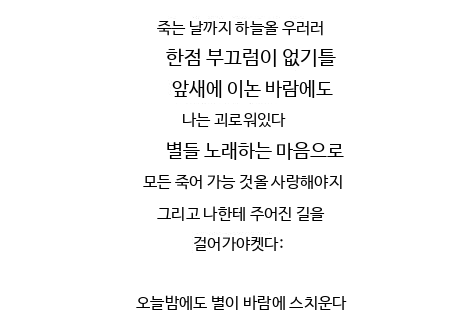

In [ ]:
img = cv2.imread('securedimg.png')

def imdemod(img,pw,M):
  h,w,none = img.shape
  QR = img[5:5+M,w-M-10:w-10, :]
  result = qrdecode(QR,pw)

  #QR 해독 후 지우기
  color = img[54,w-9]
  img[5:5+M,w-M-10:w-10, :] = color
  texts = []
  boxes = []
  for detection in result:
      box = detection[0]
      text = detection[1]

      texts.append(text)
      boxes.append(box)
  #텍스트 그리기

  template = img

  #폰트 로드
  font_path = 'NanumBarunGothic'

  # 텍스트와 상자 그리기
  pil_img = Image.fromarray(template)
  draw = ImageDraw.Draw(pil_img)

  for text, box in zip(texts, boxes):
      top_left, _, bottom_right, _ = box
      box_height = bottom_right[1] - top_left[1]  # 상자의 높이 계산
      font_size = int(0.8 * box_height)
      font = ImageFont.truetype(font_path, font_size)
      draw.text((top_left[0], top_left[1]), text, font=font, fill=0)

  text_img = np.array(pil_img)

  return(text_img)


I = imdemod(img,"123456",150)
cv2_imshow(I)

#감사합니다!
마음껏 이미지를 변조 후 복조 해보세요!

노이즈가 강한 비정형 이미지의 경우, 또는 휴대폰 화면 캡쳐등의 텍스트가 작은 경우는 실행이 안될 수 있습니다.

텍스트의 양이 많은 정형 이미지의 경우 QR크기를 200에서 더 늘려주세요!


In [1]:
I1 = cv2.imread('/content/drive/MyDrive/kang.PNG')

#QR 크기
M = 200

cv2_imshow(I1)

pw = "123456"

I2 = immod(I1,pw,M)

cv2_imshow(I2)

I3 = imdemod(I2,pw,M)
cv2_imshow(I3)

NameError: ignored

In [ ]:
cv2.imwrite('modded.png',I2)
cv2.imwrite('demodded.png',I3)

True